<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_YOLOv8_CV_SAM_sagittal_t1wce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)
- [K-Fold Cross Validation with Ultralytics](https://docs.ultralytics.com/guides/kfold-cross-validation/)
- [Train YOLOv5 + Cross Validation + Ensemble + W&B](https://www.kaggle.com/code/ayuraj/train-yolov5-cross-validation-ensemble-w-b)
- [ Is model ensembling available for Yolov8? #3665 ](https://github.com/ultralytics/ultralytics/issues/3665)
- [ Model ensembling with yolov8 #3036 ](https://github.com/ultralytics/ultralytics/issues/3036)
- [ YOLOV8 Model Ensembling #6113 ](https://github.com/ultralytics/ultralytics/issues/6113)

## Setting for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## YOLO v8 with K-Fold

### Training

In [ ]:
!pip install ultralytics
!pip install pyyaml
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.1/873.1 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [ ]:
files = os.listdir('./sagittal_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00071_183


In [ ]:
with open(os.path.join('./sagittal_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(512, 512, 3)


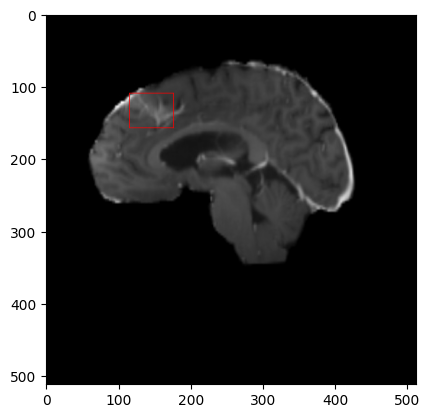

In [ ]:
img = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [ ]:
train_images = os.listdir('./sagittal_t1wce_2_class/images/train')
test_images = os.listdir('./sagittal_t1wce_2_class/images/test')
train_labels = os.listdir('./sagittal_t1wce_2_class/labels/train')
test_labels = os.listdir('./sagittal_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

264 70
264 70


In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./sagittal_t1wce_2_class/images/train', image))

In [ ]:
train_images = os.listdir('./sagittal_t1wce_2_class/images/train')
test_images = os.listdir('./sagittal_t1wce_2_class/images/test')
train_labels = os.listdir('./sagittal_t1wce_2_class/labels/train')
test_labels = os.listdir('./sagittal_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

264 70
264 70


In [ ]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./sagittal_t1wce_2_class/images/val'):
    shutil.rmtree('./sagittal_t1wce_2_class/images/val')
if os.path.exists('./sagittal_t1wce_2_class/labels/val'):
    shutil.rmtree('./sagittal_t1wce_2_class/labels/val')

os.mkdir('./sagittal_t1wce_2_class/images/val')
os.mkdir('./sagittal_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./sagittal_t1wce_2_class/images/train', image), './sagittal_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./sagittal_t1wce_2_class/labels/train', label), './sagittal_t1wce_2_class/labels/val')

In [ ]:
from pathlib import Path

dataset_path = Path("./sagittal_t1wce_2_class")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*.txt"))  # all data in 'labels'

In [ ]:
print(labels)

[PosixPath('sagittal_t1wce_2_class/labels/test/00000_102.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00000_121.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00000_140.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00000_159.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00002_110.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00002_129.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00002_147.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00002_166.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00003_154.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00003_173.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00003_192.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00003_211.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00005_106.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00005_125.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00005_143.txt'), PosixPath('sagittal_t1wce_2_class/labels/test/00006_13

In [ ]:
text ="""
path: ../sagittal_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [ ]:
import yaml
yaml_file = "./fixed_path.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes)

In [ ]:
import pathlib
import pandas as pd

indx = [pathlib.Path(label).stem for label in labels]  # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
from collections import Counter

for label in labels:
    lbl_counter = Counter()

    with open(label, "r") as lf:
        lines = lf.readlines()

    for line in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(line.split(" ")[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0)  # replace `nan` values with `0.0`

In [ ]:
labels_df

,negative,positive
00000_102,0.0,0.0
00000_121,0.0,0.0
00000_140,0.0,0.0
00000_159,0.0,0.0
00002_110,0.0,0.0
...,...,...
00187_135,0.0,0.0
00187_170,0.0,0.0
00192_244,0.0,0.0
00192_280,0.0,0.0


In [ ]:
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)  # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"split_{n}"] = ratio

In [ ]:
import datetime

supported_extensions = ".jpg"

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
  images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": '../' + split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

In [ ]:
import shutil

for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
from ultralytics import YOLO

weights_path = "./yolov8n.pt"
model = YOLO(weights_path, task="detect")

100%|██████████| 6.25M/6.25M [00:00<00:00, 162MB/s]


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wandb login --relogin 4703b281064fe4613044a2eda64e69d557e28906

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import gc
results = {}

# Define your additional arguments here
project = "brain_tumor_sagittal"
epochs = 50

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml, epochs=epochs, batch=-1, project=project, device=0)  # include any train arguments
    results[k] = model.metrics  # save output metrics for further analysis
    del dataset_yaml
    gc.collect()

Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_sagittal, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

train: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_1/train/labels... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 1573.72it/s]

train: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_1/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 542.07it/s]

val: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to brain_tumor_sagittal/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00059375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_sagittal/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.55G      1.808      4.785      1.539         66        640: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.69s/it]

                   all         67         72   0.000889      0.273   0.000625   0.000292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.47G      1.806      4.808      1.518         64        640: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         67         72    0.00112      0.326   0.000773   0.000412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       9.5G      1.706      4.559      1.423         54        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         67         72    0.00279      0.751     0.0194    0.00779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.51G      1.452      3.909      1.199         72        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         67         72    0.00306       0.83     0.0489     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       9.5G      1.322      3.295      1.154         63        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         67         72    0.00287      0.764     0.0032    0.00198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       9.5G      1.146      2.923      1.111         55        640: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         67         72    0.00278      0.752     0.0684     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       9.5G      1.162       2.64      1.119         60        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         67         72    0.00273      0.751      0.143     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.53G      1.161       2.51      1.099         65        640: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         67         72    0.00262      0.721     0.0636     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       9.5G      1.147      2.371      1.087         58        640: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         67         72    0.00281      0.777     0.0214     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.51G      1.133      2.331      1.085         65        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         67         72    0.00294      0.818     0.0486     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       9.5G      1.123      2.375      1.068         57        640: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         67         72    0.00164      0.457     0.0806     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       9.5G      1.137      2.199      1.053         63        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         67         72    0.00169      0.474     0.0737     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.45G      1.117      2.214      1.062         56        640: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         67         72   0.000949      0.265     0.0432     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.45G      1.095      2.044      1.065         59        640: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         67         72    0.00237      0.648      0.289      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.51G      1.026      1.982      1.037         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

                   all         67         72    0.00202      0.543      0.186      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.51G      1.092      2.015      1.072         60        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         67         72    0.00229      0.595      0.251      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       9.5G      1.076      1.968      1.059         54        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         67         72    0.00275      0.762      0.204      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.53G      1.123      1.887      1.084         59        640: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         67         72    0.00313      0.874      0.305      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       9.5G      1.096      1.892      1.033         52        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         67         72      0.529      0.307       0.38       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.51G      1.136      1.883      1.097         60        640: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         67         72        0.5      0.486      0.433      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       9.5G      1.037      1.799      1.041         65        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         67         72      0.507      0.401      0.397      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.45G      1.005      1.712       1.03         74        640: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         72      0.515      0.316      0.335      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       9.5G      1.057      1.643      1.056         62        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         67         72      0.531      0.161      0.309      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.51G      0.935      1.543     0.9889         75        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         72      0.486      0.459      0.382      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.53G      1.005      1.579      1.033         64        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         67         72       0.51       0.46      0.421      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       9.5G     0.9603      1.527      1.018         64        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         67         72      0.454      0.592      0.475      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.45G      1.028       1.55      1.063         64        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         67         72      0.463      0.702      0.521      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.51G     0.9766      1.499      1.037         73        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         67         72      0.469       0.63      0.486      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       9.5G     0.9849      1.401       1.02         61        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         67         72      0.419      0.758      0.508      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.51G      1.018      1.459      1.023         58        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         67         72      0.486      0.659      0.573      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       9.5G      1.027      1.459      1.046         69        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         67         72      0.484      0.746      0.579      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       9.5G     0.9324       1.42      1.016         71        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         67         72      0.486      0.693      0.522      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.45G     0.8712      1.325     0.9771         60        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         67         72      0.441       0.79       0.53      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       9.5G     0.9092      1.317     0.9926         72        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         67         72      0.436      0.809      0.605       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       9.5G     0.9077      1.318     0.9897         62        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         67         72      0.449      0.672      0.529      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.52G     0.9262      1.289     0.9967         54        640: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         67         72      0.485      0.631      0.519      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       9.5G     0.8953      1.302     0.9948         67        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         67         72       0.52      0.667      0.582       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       9.5G     0.9206      1.264      1.005         53        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         67         72      0.518      0.698      0.686      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       9.5G      0.884      1.219     0.9962         61        640: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         67         72      0.467      0.644      0.612      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       9.5G     0.8635      1.148     0.9739         66        640: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         67         72       0.46      0.765      0.634      0.456


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.45G     0.7941      1.244     0.9397         39        640: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         67         72       0.48      0.703      0.561      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.45G     0.7701       1.16     0.9432         41        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         67         72      0.468      0.764      0.601      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.45G     0.7363      1.156     0.9197         42        640: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         67         72      0.515       0.67      0.597      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.45G     0.7196      1.116     0.9121         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         67         72      0.471      0.724      0.635      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.45G     0.7207      1.082     0.9348         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         67         72      0.717      0.587      0.699      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.45G     0.7116      1.016     0.8999         39        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         67         72      0.495      0.765      0.697      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.45G      0.684     0.9749     0.9066         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         67         72      0.738      0.642      0.725      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.45G     0.6711     0.9417     0.8894         43        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         67         72        0.7      0.648      0.725      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.45G     0.6671      0.877       0.89         41        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         67         72      0.602      0.735      0.704      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.45G     0.6601     0.8764     0.8914         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         67         72      0.647      0.714      0.705      0.519



50 epochs completed in 0.097 hours.
Optimizer stripped from brain_tumor_sagittal/train2/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_sagittal/train2/weights/best.pt, 6.3MB

Validating brain_tumor_sagittal/train2/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


                   all         67         72      0.735      0.634      0.725      0.546
              negative         34         38      0.701      0.679      0.728      0.557
              positive         33         34       0.77      0.589      0.721      0.536
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to brain_tumor_sagittal/train2
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_2/split_2_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_sagittal, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freez

wandb: Currently logged in as: pch-neurodive-osa036 (pch-neurodive-osa036-japan). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 1.43G reserved, 0.14G allocated, 13.18G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         1.604          26.2         16.25        (1, 3, 640, 640)                    list
     3011238       16.39         0.329         26.28         21.52        (2, 3, 640, 640)                    list
     3011238       32.78         0.558         19.81          19.1        (4, 3, 640, 640)                    list
     3011238       65.56         1.065         27.16         29.73        (8, 3, 640, 640)                    list
     3011238       131.1         1.934         38.94         46.37       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_2/train/labels... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 1790.69it/s]

train: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_2/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 775.31it/s]

val: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to brain_tumor_sagittal/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00084375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_sagittal/train22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.4G     0.7655      1.059     0.9408         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         67         72      0.736      0.834      0.874      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.4G     0.7479      1.016     0.9515         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         72      0.801      0.787      0.872       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.4G     0.7136     0.9716     0.9306         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         67         72      0.677      0.871      0.846      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.4G     0.7552      1.073     0.9373         56        640: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         67         72      0.709      0.864      0.864      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.4G     0.7701      1.043     0.9475         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         67         72      0.719      0.889       0.87      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.4G     0.7335     0.9811     0.9187         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         67         72      0.852      0.826      0.897      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.4G     0.7374     0.9693     0.9463         56        640: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         67         72       0.83      0.805      0.886       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.4G     0.7187     0.9196     0.9254         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         67         72      0.672      0.898      0.864      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.4G     0.7482     0.9241     0.9159         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         67         72       0.77      0.876      0.893      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.4G     0.7446     0.8979     0.9115         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         67         72      0.647      0.843      0.794       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.4G     0.7618     0.8968     0.9235         56        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         67         72       0.76      0.759      0.784      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      13.4G     0.7628      0.839     0.9447         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         67         72      0.696      0.883       0.83      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.4G     0.7243     0.8126     0.9441         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         67         72      0.659      0.801      0.781      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.4G     0.7363     0.9384     0.9308         57        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         67         72      0.643      0.857      0.797      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.4G     0.7332     0.8526     0.9197         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         67         72      0.601      0.857       0.77      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.4G     0.7336     0.8055     0.9189         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         67         72      0.742      0.739      0.807      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.4G     0.7392     0.8526     0.9161         56        640: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         72      0.789      0.725      0.797      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.4G     0.7101     0.8164     0.9241         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         67         72      0.699      0.788      0.817      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.4G     0.7242     0.7654     0.9229         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         67         72      0.784        0.7      0.775      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      13.4G     0.7561      0.811     0.9334         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         67         72      0.616      0.749      0.705      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.4G     0.7181      0.761      0.936         53        640: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         67         72      0.708      0.725      0.755      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.4G     0.7132     0.7432     0.9227         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         67         72      0.653      0.705      0.678      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      13.4G     0.7201     0.7316     0.9085         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         67         72      0.742      0.707      0.717      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.4G      0.713      0.751     0.9202         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         67         72      0.668      0.645      0.705      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.4G     0.7209     0.7014     0.9179         57        640: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         67         72      0.515      0.664      0.662      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.4G     0.7228     0.7304     0.9373         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         67         72      0.611      0.794      0.778      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.4G     0.7306     0.7343     0.9202         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         67         72      0.581      0.802      0.677      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.4G     0.6904       0.72     0.9016         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         67         72      0.543      0.748       0.67      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.4G     0.6742     0.6405      0.908         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         72      0.574      0.767      0.697      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      13.4G     0.6589      0.635     0.8941         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         72      0.617      0.756      0.674      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      13.4G     0.6703      0.634     0.9004         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         67         72      0.614      0.796      0.778      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.4G     0.7151     0.6829     0.9147         57        640: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         67         72       0.58      0.868      0.774      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      13.4G     0.7179     0.6792     0.8923         56        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         67         72      0.603      0.765      0.729      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      13.4G     0.6977     0.6939     0.9085         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         67         72      0.709      0.665      0.723      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      13.4G     0.6408     0.6116     0.8783         58        640: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         67         72      0.654       0.81      0.733      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.4G     0.6494       0.58     0.8939         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         67         72       0.63      0.756      0.719      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      13.4G     0.6726     0.5592     0.8937         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         67         72      0.628      0.834       0.73       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      13.4G     0.6132     0.5398     0.8775         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         67         72      0.653      0.675      0.701      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.4G     0.6133      0.516     0.8877         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         67         72       0.61      0.704      0.698      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.4G     0.6153     0.5243     0.8719         54        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         67         72      0.622       0.79      0.728      0.601


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.4G     0.5959     0.5117     0.8806         54        640: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all         67         72      0.629      0.796      0.775      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      13.4G     0.5786      0.486     0.8573         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         67         72      0.699      0.691      0.767      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      13.4G     0.5729     0.4709     0.8673         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         67         72      0.594      0.812      0.771      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      13.4G     0.5693     0.4794     0.8544         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         72      0.628      0.735      0.763      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.4G      0.586     0.4647     0.8779         54        640: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         67         72      0.705      0.699      0.745      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.4G     0.5466     0.4363     0.8614         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         67         72      0.674      0.764      0.773      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.4G     0.5579     0.4563     0.8558         57        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         67         72      0.761      0.719      0.794      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.4G     0.5215     0.4362      0.856         52        640: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         72      0.662      0.794      0.796      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.4G      0.526     0.4219     0.8526         57        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         67         72      0.653      0.791        0.8      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      13.4G     0.5048     0.4147      0.847         55        640: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         67         72      0.726      0.701      0.802      0.681



50 epochs completed in 0.091 hours.
Optimizer stripped from brain_tumor_sagittal/train22/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_sagittal/train22/weights/best.pt, 6.3MB

Validating brain_tumor_sagittal/train22/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


                   all         67         72      0.852      0.827      0.897      0.771
              negative         34         35      0.915      0.743       0.92      0.789
              positive         33         37      0.789       0.91      0.874      0.752
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to brain_tumor_sagittal/train22


lr/pg0,▁▂▂▃▄▄▄▅▅▆▆▆▇▇▇▇██████████▇▇▆▆▆▅▅▄▄▃▃▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▅▆▆▆▇▇▇▇██████████▇▇▆▆▆▅▅▄▄▃▃▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▅▆▆▆▇▇▇▇██████████▇▇▆▆▆▅▅▄▄▃▃▂▂▁
metrics/mAP50(B),▇▇▆▇██▇█▅▆▄▅▅▅▆▄▄▁▂▂▄▁▁▂▄▄▃▃▃▃▂▂▄▄▄▄▄▅▅█
metrics/mAP50-95(B),█▇▆▇████▄▆▅▅▅▅▅▄▄▁▁▁▃▁▁▂▃▄▃▂▃▃▂▃▄▄▄▄▅▅▅█
metrics/precision(B),▅▇▄▅█▇▄▆▆▄▄▃▆▇▅▆▅▃▆▄▃▂▁▂▃▂▂▅▃▃▃▃▃▅▂▃▄▆▄█
metrics/recall(B),▆▅▇▇▆▅█▇▄█▅▇▄▃▅▃▃▃▃▁▅▅▄▄▅▇▄▂▄▆▂▃▅▂▆▃▄▃▅▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇█▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▇▇▆▅▆▄▄▃▃▃▃▂▂▁▁


Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_3/split_3_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_sagittal, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.40G reserved, 0.14G allocated, 14.21G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.497         20.54         13.98        (1, 3, 640, 640)                    list
     3011238       16.39         0.333         22.37         18.03        (2, 3, 640, 640)                    list
     3011238       32.78         0.564         19.44         20.34        (4, 3, 640, 640)                    list
     3011238       65.56         1.076         24.42         27.92        (8, 3, 640, 640)                    list
     3011238       131.1         1.944         38.91         45.79       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_3/train/labels... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 400.41it/s]

train: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_3/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 388.32it/s]

val: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_3/val/labels.cache


Plotting labels to brain_tumor_sagittal/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000609375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_sagittal/train222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.2G     0.7601     0.9831     0.9377         35        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         67         70      0.783      0.942      0.947       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.1G     0.7435     0.9916     0.9267         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         67         70      0.814      0.916      0.962      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.1G     0.7365      0.986     0.9247         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         67         70      0.838      0.907      0.946      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.1G     0.7459     0.9721     0.9402         36        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         67         70      0.896      0.872      0.938        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.1G     0.7089     0.9074       0.93         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         67         70      0.874      0.862      0.922      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.1G     0.7543     0.9255     0.9264         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         67         70       0.83      0.863      0.911      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.1G     0.7293     0.9568     0.9583         34        640: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         67         70      0.712      0.883      0.868       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.1G     0.7571     0.9269     0.9413         33        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         67         70       0.64      0.924      0.814      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.1G     0.7394     0.9169     0.9187         34        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         67         70      0.735      0.826      0.785      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.1G     0.7197     0.9396     0.9196         36        640: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         70      0.599      0.882      0.756      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.1G      0.721     0.9137     0.9201         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         67         70      0.579      0.919      0.734      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.1G     0.7181     0.8935     0.9224         33        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         67         70        0.6      0.797      0.734       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.1G     0.8018     0.8669     0.9483         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         67         70      0.571      0.794      0.669      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.1G     0.7561      0.816     0.9377         36        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         70      0.616      0.735      0.679       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.1G     0.7846     0.8427     0.9655         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         67         70      0.609      0.772      0.679      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.1G     0.8623     0.8642      0.983         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         67         70      0.778      0.639      0.733      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.1G     0.7707     0.8288     0.9408         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         67         70      0.658      0.749        0.7      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.1G     0.7741     0.8345     0.9195         35        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         67         70      0.514      0.842      0.627      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.1G     0.8164     0.8478     0.9604         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         67         70      0.506      0.874      0.696      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.1G     0.7474     0.8553     0.9523         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         67         70       0.58      0.847      0.659      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.1G     0.7638     0.8425     0.9328         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         67         70       0.57      0.862      0.654      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.1G     0.7497     0.8083     0.9313         37        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         67         70      0.567      0.749      0.629      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.1G       0.76     0.7993     0.9372         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         67         70      0.473      0.629      0.591       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.1G     0.7229     0.7295     0.9363         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         67         70      0.417      0.456      0.458      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.1G     0.7879     0.7619     0.9409         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         67         70       0.21       0.35      0.143     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.1G     0.7409     0.7446     0.9316         34        640: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         67         70      0.529      0.414      0.438      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.1G     0.8023     0.7901     0.9469         32        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         67         70      0.498      0.704      0.605      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.1G     0.7886     0.7759     0.9458         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         67         70      0.489      0.749      0.603      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.1G     0.7643     0.7447       0.93         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         67         70      0.509      0.701      0.558      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.1G     0.7152     0.6533     0.9203         34        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         67         70      0.491      0.729      0.564      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.1G     0.7293     0.6363     0.9205         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         67         70       0.62      0.695      0.655      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.1G     0.7064      0.605     0.9096         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         70       0.68       0.74      0.716      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.1G     0.7224     0.6457     0.9055         33        640: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         67         70      0.533      0.766      0.671      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.1G     0.6967        0.6     0.9107         34        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         67         70      0.685      0.794      0.787      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.1G     0.6554     0.5674     0.9079         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         67         70      0.604      0.791      0.696      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.1G     0.6718     0.5827     0.9116         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         67         70      0.616      0.769      0.718      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.1G     0.6333     0.5742     0.8968         34        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         67         70      0.659      0.725      0.732      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.1G       0.68     0.5414     0.9022         34        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         67         70      0.644      0.784      0.743      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.1G     0.6527     0.5488     0.8654         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         67         70      0.577      0.817      0.699      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.1G     0.6308     0.4834     0.8774         33        640: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         67         70      0.593      0.811      0.711      0.563


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.1G     0.6328     0.4998     0.8876         34        640: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         67         70      0.788      0.767      0.802      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.1G     0.6017     0.4792     0.8721         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         67         70       0.74      0.808      0.813      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.1G     0.5807     0.4503     0.8757         35        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         67         70      0.788      0.698       0.77      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.1G     0.5952     0.4704     0.8646         38        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         67         70      0.745      0.752       0.79      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.1G     0.5762     0.4189     0.8665         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         67         70      0.727      0.836      0.836      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.1G     0.5726     0.4354     0.8672         34        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         67         70      0.701       0.84      0.831      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.1G     0.5436     0.4149     0.8576         35        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         67         70      0.741      0.782      0.811      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.1G     0.5418     0.4121     0.8548         35        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         67         70      0.651      0.907      0.819       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.1G     0.5238     0.3884     0.8497         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         67         70      0.622      0.922      0.809      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.1G     0.5259     0.3961     0.8428         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         67         70      0.677      0.862      0.824      0.675



50 epochs completed in 0.097 hours.
Optimizer stripped from brain_tumor_sagittal/train222/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_sagittal/train222/weights/best.pt, 6.3MB

Validating brain_tumor_sagittal/train222/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


                   all         67         70      0.803      0.904      0.961      0.816
              negative         30         31      0.656      0.935      0.943      0.809
              positive         37         39      0.949      0.872      0.979      0.824
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to brain_tumor_sagittal/train222


lr/pg0,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
metrics/mAP50(B),████▇▇▆▆▅▅▄▄▅▄▄▄▄▄▃▁▁▃▃▃▄▅▄▆▅▅▅▄▆▆▅▆▆▆▆█
metrics/mAP50-95(B),████▇▆▆▆▅▅▄▄▅▄▃▄▄▃▂▁▁▃▃▂▃▄▄▅▄▄▅▄▆▆▅▅▆▆▆█
metrics/precision(B),▆▇▇█▇▅▄▆▃▄▃▄▆▅▂▂▃▃▂▁▃▂▂▂▄▅▃▅▄▅▄▃▆▆▆▆▅▆▄▇
metrics/recall(B),███▇▇▇█▆█▆▆▅▄▅▇▇▇▅▄▂▁▅▅▅▅▅▆▆▆▅▆▆▆▆▅▅▇▆█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆▆▅▆▆▅▆▅▅▅▇▆█▆▆▇▆▆▆▅▅▇▆▆▅▅▅▅▄▃▄▄▃▃▂▂▂▁▁▁


Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_4/split_4_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_sagittal, name=train2222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.66G reserved, 0.14G allocated, 13.94G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.782         82.84         76.91        (1, 3, 640, 640)                    list
     3011238       16.39         0.336         22.28          16.6        (2, 3, 640, 640)                    list
     3011238       32.78         0.566         19.99         20.58        (4, 3, 640, 640)                    list
     3011238       65.56         1.078          25.9         28.67        (8, 3, 640, 640)                    list
     3011238       131.1         1.946         38.79         45.86       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_4/train/labels... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 1167.93it/s]

train: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_4/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 490.44it/s]

val: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_4/val/labels.cache


Plotting labels to brain_tumor_sagittal/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006484375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_sagittal/train2222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.4G     0.7016      1.048     0.9326         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         67         75      0.821      0.875       0.93      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.4G     0.6906     0.9415     0.9008         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         75      0.779      0.841      0.918       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.3G     0.7087     0.9771     0.9405         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         67         75      0.655      0.955       0.88      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.4G     0.7349     0.9542     0.9209         24        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         67         75      0.684      0.817      0.802      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.4G     0.7708     0.9715     0.9527         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         67         75      0.687      0.882      0.866      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.3G     0.7528      1.011     0.9558         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         67         75      0.712       0.77      0.818       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.3G     0.7192     0.8936      0.926         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         67         75      0.705      0.783      0.822       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.4G     0.7733     0.9345      0.928         18        640: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         67         75      0.755      0.788      0.831      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.3G     0.7368     0.9634     0.9256         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         67         75      0.669      0.763      0.775      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.4G     0.7489     0.8748     0.9365         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         67         75      0.512       0.82      0.669      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.3G     0.7369      0.847     0.9334         19        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         67         75      0.623      0.775      0.732      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.3G     0.6992     0.8772     0.9399         20        640: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         67         75      0.474      0.637      0.551       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.4G     0.7581     0.8968     0.9247         18        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         67         75      0.507      0.851       0.66      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.4G      0.773     0.8397     0.9447         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         67         75      0.564      0.692      0.623      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.3G     0.7861     0.9009     0.9339         20        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         67         75      0.574      0.819      0.736      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.4G     0.7524     0.8106     0.9192         18        640: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         67         75      0.527      0.665      0.572      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.4G      0.781     0.8333     0.9327         18        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         67         75      0.499      0.725      0.564      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.3G     0.7715     0.8214     0.9657         20        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         67         75      0.475      0.677      0.562      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.3G     0.7715     0.7911     0.9387         20        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         67         75      0.449      0.556      0.547      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.3G     0.8224     0.8539     0.9772         19        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         67         75       0.48      0.724      0.601      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.4G      0.759     0.7589     0.9641         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         67         75      0.512      0.702      0.577       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.3G      0.759     0.8893     0.9332         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         67         75      0.455       0.78      0.608      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.3G      0.778     0.7627     0.9413         19        640: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         67         75      0.513      0.577      0.504      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.4G     0.7639     0.8406     0.9379         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         67         75      0.462      0.681      0.485      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.4G     0.7584     0.8416     0.9464         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         67         75      0.526      0.604      0.539      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.4G     0.7409     0.8023     0.9498         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         67         75      0.397      0.752       0.49      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.4G     0.7796     0.8008      0.937         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         67         75      0.463      0.753       0.53      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.3G      0.772     0.7484     0.9438         20        640: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         67         75      0.425        0.8      0.496      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.3G     0.8607     0.7899     0.9991         20        640: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         67         75      0.466      0.687      0.493      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.4G     0.8244      0.739     0.9726         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         67         75        0.4      0.708      0.437      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.3G     0.8427     0.7414       0.98         20        640: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         67         75      0.381      0.608      0.427      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.4G     0.7249     0.6698     0.9224         18        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         67         75      0.441      0.637      0.493      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.4G     0.7503     0.6367     0.9508         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         67         75      0.525      0.623      0.471      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.3G      0.749     0.6868     0.9531         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         67         75      0.546      0.656       0.57      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.3G     0.7174     0.6134      0.922         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         67         75      0.587      0.745       0.65      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.3G     0.7394     0.6181     0.9116         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         67         75       0.57      0.688      0.595      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.4G     0.6797     0.5617     0.9012         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         67         75      0.532      0.765      0.633       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.4G     0.6723     0.5538     0.9014         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         67         75      0.663      0.636      0.675      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.4G       0.63     0.5248      0.914         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         67         75      0.595       0.75      0.724       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.3G     0.6434     0.5214     0.8818         19        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         67         75      0.654       0.65      0.671      0.523


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.4G     0.6294     0.5197     0.8911         18        640: 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         67         75      0.647      0.677      0.734      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.3G     0.6557     0.5084     0.8733         20        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         67         75      0.633      0.773      0.728      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.4G     0.6208     0.4695      0.853         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         67         75      0.696      0.728      0.706      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.4G     0.6332     0.4759     0.8781         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         67         75      0.663      0.802      0.756      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.4G     0.5959     0.4805      0.887         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         67         75      0.698      0.738       0.74      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.4G     0.5751     0.4553     0.8677         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         67         75      0.686      0.777      0.762      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.4G     0.5529     0.4314     0.8599         18        640: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         67         75      0.721      0.765      0.765      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.3G     0.5951     0.4285     0.8488         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         67         75      0.729      0.746      0.787      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.3G     0.5611     0.4102     0.8511         19        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         67         75      0.687      0.785      0.777      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.3G     0.5602     0.4162     0.8551         19        640: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         67         75       0.68       0.77      0.776      0.616



50 epochs completed in 0.103 hours.
Optimizer stripped from brain_tumor_sagittal/train2222/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_sagittal/train2222/weights/best.pt, 6.3MB

Validating brain_tumor_sagittal/train2222/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


                   all         67         75      0.821      0.876       0.93      0.776
              negative         36         41      0.713      0.976      0.918      0.795
              positive         31         34      0.929      0.775      0.942      0.756
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to brain_tumor_sagittal/train2222


lr/pg0,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
metrics/mAP50(B),██▇▆▆▇▇▆▅▃▄▄▃▃▃▃▃▄▂▂▂▂▂▂▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆█
metrics/mAP50-95(B),███▆▇▇▆▅▅▃▄▄▃▃▃▃▃▃▂▁▂▃▁▂▁▂▂▃▃▃▄▅▅▅▅▆▅▆▆█
metrics/precision(B),█▇▅▆▆▆▇▆▅▂▃▄▃▃▂▂▃▂▃▂▁▂▂▂▁▂▃▄▄▃▅▄▅▅▆▅▆▆▇█
metrics/recall(B),▇▆█▆▅▅▅▅▅▂▆▃▃▄▃▁▄▅▁▃▄▄▅▃▂▂▂▃▃▅▂▄▃▅▄▅▅▅▄▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▄▄▅▅▆▅▆▅▅▄▆▆▆▆▆▆▆▆▆▆▅▆▆██▅▅▅▅▄▄▃▃▃▃▃▂▁▂▁


Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_5/split_5_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_sagittal, name=train22222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.62G reserved, 0.14G allocated, 13.99G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.734         32.99         20.61        (1, 3, 640, 640)                    list
     3011238       16.39         0.340         125.4         66.19        (2, 3, 640, 640)                    list
     3011238       32.78         0.570         93.51         74.98        (4, 3, 640, 640)                    list
     3011238       65.56         1.078         95.83         72.64        (8, 3, 640, 640)                    list
     3011238       131.1         1.946         92.44          76.2       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_5/train/labels... 268 images, 0 backgrounds, 0 corrupt: 100%|██████████| 268/268 [00:01<00:00, 235.41it/s]

train: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_5/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 133.77it/s]


val: New cache created: /content/sagittal_t1wce_2_class/2024-09-19_5-Fold_Cross-val/split_5/val/labels.cache
Plotting labels to brain_tumor_sagittal/train22222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000640625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_sagittal/train22222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.4G     0.7319     0.9858     0.9316         28        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         66         67      0.893      0.911      0.967      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.3G     0.6985     0.9605      0.913         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         66         67      0.771      0.955      0.955      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.3G     0.7062     0.9268      0.919         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         66         67      0.757      0.926      0.925      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.3G     0.7234      1.126     0.9085         24        640: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         66         67      0.804      0.858       0.91      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.3G     0.7575     0.9952     0.9417         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         66         67      0.739       0.91      0.897      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.3G     0.7722      0.956     0.9416         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         66         67      0.755      0.868      0.899      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.3G     0.7182     0.9011     0.9215         24        640: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         66         67      0.706      0.925       0.91      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.3G     0.7208     0.8681      0.916         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         66         67      0.738      0.718       0.83       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.3G     0.7201     0.9006     0.9434         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         66         67      0.687      0.834      0.879       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.3G     0.7293     0.8832     0.9311         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         66         67      0.612      0.868      0.784      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.3G     0.7359     0.9284     0.9258         25        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         66         67       0.65       0.74      0.759      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.3G     0.7615     0.8966      0.943         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         66         67      0.666      0.734      0.772      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.3G     0.7966     0.8139     0.9395         24        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         66         67      0.605      0.798      0.779      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.3G     0.7938     0.8453     0.9476         24        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         66         67      0.569      0.782      0.752      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.3G     0.7563     0.7978      0.916         25        640: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         66         67      0.597      0.814      0.774      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.3G     0.7911     0.8216     0.9238         26        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         66         67      0.684      0.696      0.704       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.3G     0.7557     0.9261     0.9281         21        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         66         67      0.503      0.763      0.646      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.3G     0.7498     0.9283     0.9259         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         66         67       0.55      0.794       0.71      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.3G     0.7713     0.8449     0.9339         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         66         67      0.653      0.822      0.823      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.3G     0.7262     0.8307     0.9367         23        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         66         67      0.777      0.547      0.559      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.3G     0.7771     0.8272     0.9307         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         66         67      0.324      0.354       0.23      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.3G     0.8214     0.8158     0.9627         23        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         66         67      0.613      0.443      0.392        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.3G     0.7576     0.8759     0.9474         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         66         67      0.695      0.414      0.418        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.3G     0.7345      0.734     0.9271         26        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         66         67      0.479      0.759      0.546      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.3G     0.7866     0.7995     0.9453         25        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         66         67      0.436      0.759      0.547       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.3G     0.7778     0.9455     0.9491         24        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         66         67      0.784      0.522      0.639       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.3G      0.758     0.7727     0.9465         23        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         66         67       0.51      0.705      0.538      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.3G     0.7808     0.8076     0.9391         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         66         67      0.559       0.57      0.573      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.3G     0.7118     0.8199     0.9236         22        640: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         66         67      0.481      0.687      0.535      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.3G     0.7482       0.69     0.9391         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         66         67      0.569      0.767      0.675      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.3G     0.7272     0.7596     0.9176         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         66         67      0.717      0.673      0.736      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.3G      0.741     0.6227     0.9073         23        640: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all         66         67      0.402      0.763      0.541       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.3G     0.7033     0.6335     0.9106         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         66         67      0.491      0.725      0.571      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.3G     0.6604     0.5958     0.9042         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         66         67      0.561      0.618      0.586      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.3G     0.7184     0.6126     0.9227         25        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         66         67      0.636      0.579       0.59      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.3G     0.6935     0.5887     0.9139         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         66         67      0.632      0.738      0.752      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.3G     0.6639     0.5751     0.8976         22        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all         66         67      0.637      0.674      0.668      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.3G     0.6325     0.5403     0.8775         23        640: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         66         67      0.573      0.808      0.678      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.3G      0.663     0.5246     0.8715         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         66         67       0.54      0.786      0.729      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.3G     0.6177     0.4713     0.8742         23        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         66         67      0.587      0.741      0.749      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.3G     0.6532      0.502     0.8888         24        640: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         66         67      0.514      0.773      0.678      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.3G     0.6182      0.498     0.8771         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         66         67      0.538      0.733       0.69      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.3G     0.6035     0.4666     0.8834         24        640: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         66         67      0.622      0.779      0.765      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.3G     0.5747      0.454      0.858         22        640: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         66         67      0.679      0.848      0.823      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.3G     0.5635     0.4168     0.8621         23        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         66         67      0.639      0.866      0.779      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.3G      0.568     0.4164     0.8589         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         66         67      0.631      0.828      0.754      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.3G     0.5606     0.4456     0.8617         23        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         66         67      0.691      0.764      0.799      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.3G      0.541     0.4211     0.8734         23        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         66         67      0.719      0.806      0.819       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.3G     0.5203     0.3839     0.8424         23        640: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         66         67      0.701        0.8      0.821      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.3G     0.5006     0.3725      0.825         24        640: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         66         67      0.702      0.813      0.814       0.65



50 epochs completed in 0.113 hours.
Optimizer stripped from brain_tumor_sagittal/train22222/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_sagittal/train22222/weights/best.pt, 6.3MB

Validating brain_tumor_sagittal/train22222/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


                   all         66         67      0.771      0.955      0.954      0.797
              negative         33         33      0.915      0.939      0.957      0.826
              positive         33         34      0.627      0.971      0.951      0.768
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to brain_tumor_sagittal/train22222


lr/pg0,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
metrics/mAP50(B),███▇▇▇▇▇▆▆▆▆▅▅▆▇▁▃▃▄▅▄▄▄▆▄▄▄▆▅▅▆▅▅▆▇▆▆▇█
metrics/mAP50-95(B),█████▇▇▇▆▆▆▅▅▅▅▆▁▃▃▄▅▃▄▄▅▃▄▄▅▅▅▆▅▅▆▆▆▆▆█
metrics/precision(B),█▇▆▇▆▆▆▅▅▅▄▄▅▃▄▅▁▅▆▃▇▃▄▃▆▂▃▄▅▅▄▄▃▄▅▅▅▆▆▆
metrics/recall(B),▇██▇▇█▅▇▅▅▆▆▅▆▆▆▁▂▂▆▃▅▄▅▅▆▅▄▅▅▆▆▆▅▆▇▇▆▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆▅▅▆▇▆▆▆▆▇▇▇▇▇▆▇▇█▇▆▇▇▇▆▆▆▅▄▅▅▄▅▄▄▃▃▂▂▂▁


### Inference

In [ ]:
# Manually
#  trained_model = YOLO('path/to/weights/best.pt')
trained_model = YOLO('/content/brain_tumor_sagittal/train22222/weights/best.pt')
trained_model.save('/content/drive/MyDrive/bt_best_sagittal.pt')

In [ ]:
predictions = trained_model.predict(
    source="./sagittal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/70 /content/sagittal_t1wce_2_class/images/test/00000_102.jpg: 640x640 1 positive, 33.6ms
image 2/70 /content/sagittal_t1wce_2_class/images/test/00000_121.jpg: 640x640 1 positive, 53.7ms
image 3/70 /content/sagittal_t1wce_2_class/images/test/00000_140.jpg: 640x640 1 positive, 32.2ms
image 4/70 /content/sagittal_t1wce_2_class/images/test/00000_159.jpg: 640x640 1 positive, 50.4ms
image 5/70 /content/sagittal_t1wce_2_class/images/test/00002_110.jpg: 640x640 1 positive, 26.7ms
image 6/70 /content/sagittal_t1wce_2_class/images/test/00002_129.jpg: 640x640 1 positive, 47.4ms
image 7/70 /content/sagittal_t1wce_2_class/images/test/00002_147.jpg: 640x640 1 positive, 40.6ms
image 8/70 /content/sagittal_t1wce_2_class/images/test/00002_166.jpg: 640x640 1 positive, 37.3ms
image 9/70 /content/sagittal_t1wce_2_class/images/test/00003_154.jpg: 640x640 1 positive, 26.2ms
image 10/70 /content/sagittal_t1wce_2_class/images/test/00003_173.jpg: 640x640 1 negative, 1 positive, 42.0ms
image 11/70 /con

In [ ]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['1', '0.311759', '0.361684', '0.0922891', '0.0908216', '0.620299\n']
['0', '0.312793', '0.364437', '0.095070', '0.090376']


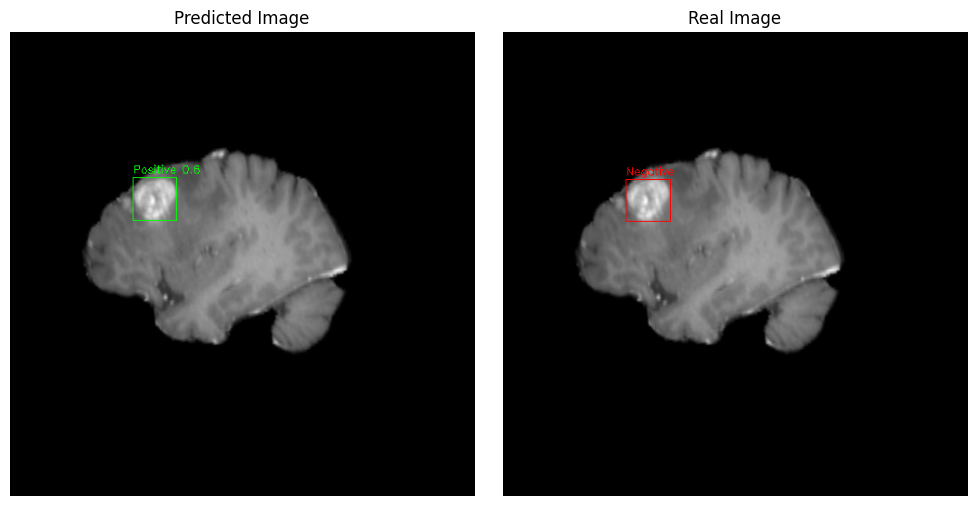

In [ ]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./sagittal_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
text = """
path: ../sagittal_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [ ]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/sagittal_t1wce_2_class/labels/test... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 1349.70it/s]

val: New cache created: /content/sagittal_t1wce_2_class/labels/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


                   all         70         77      0.712       0.92      0.911      0.768
              negative         35         39      0.916      0.841      0.922      0.736
              positive         35         38      0.509          1        0.9        0.8
Speed: 0.5ms preprocess, 19.2ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/val


In [ ]:
test_save_dir = './' + str(metrics.save_dir)

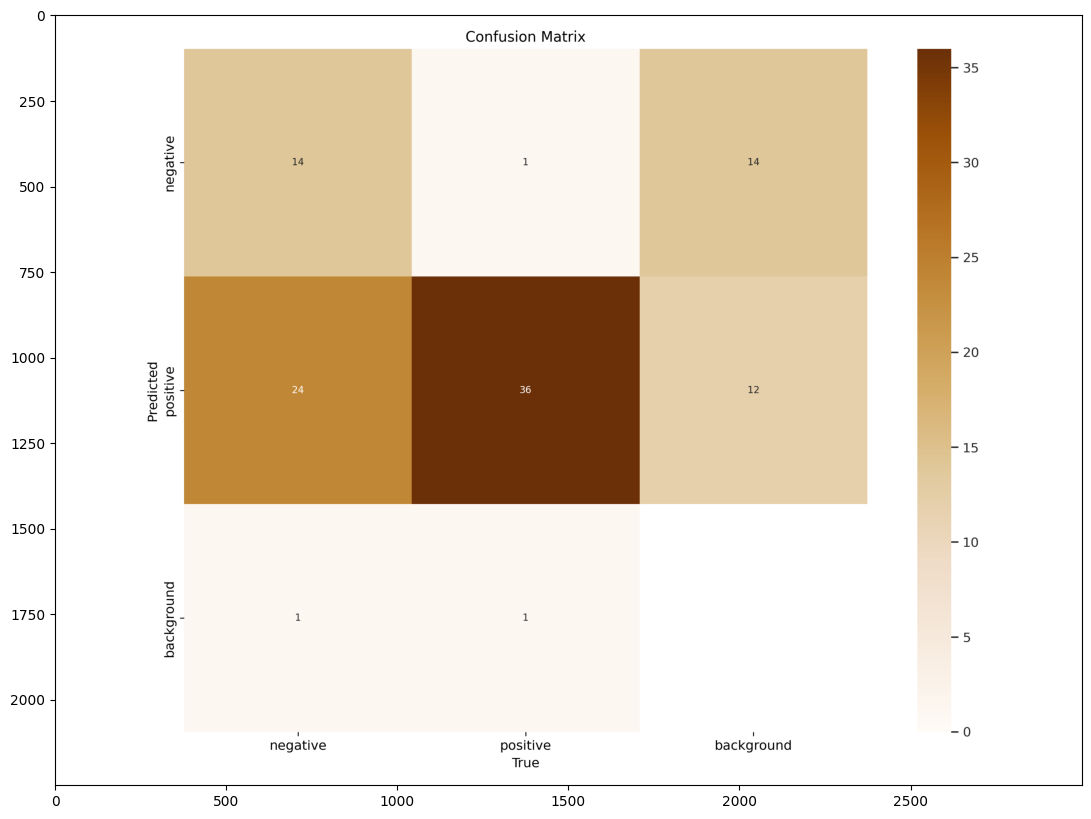

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

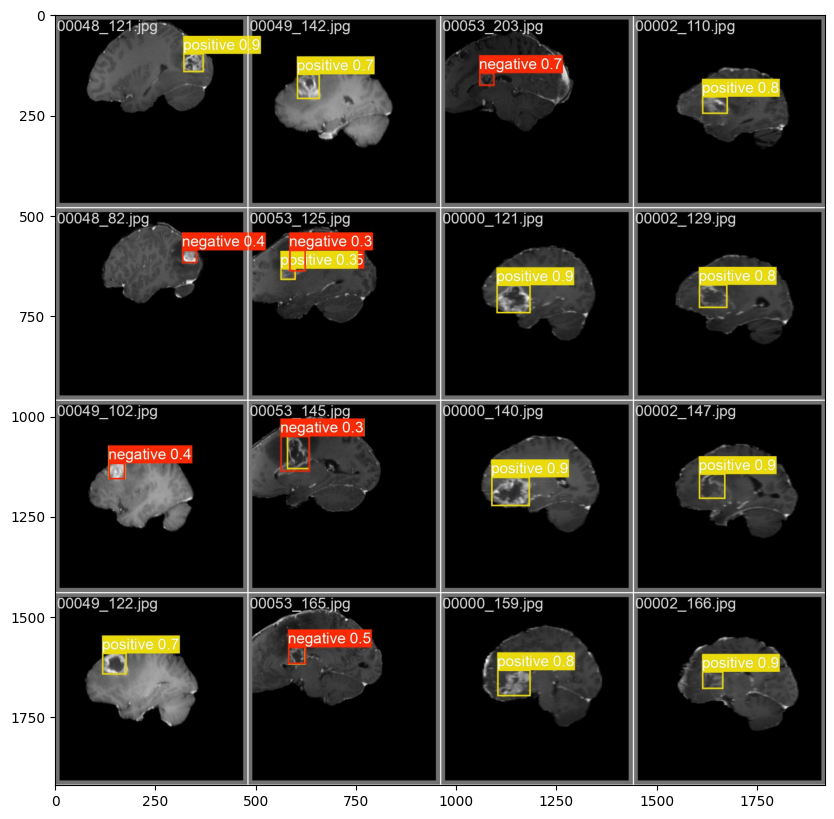

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

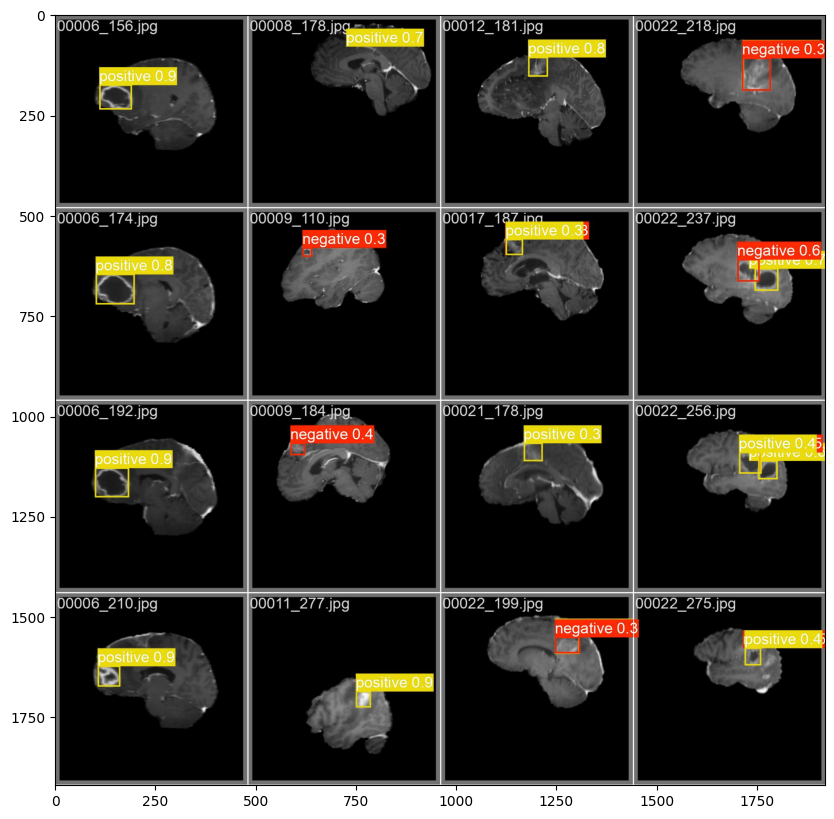

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

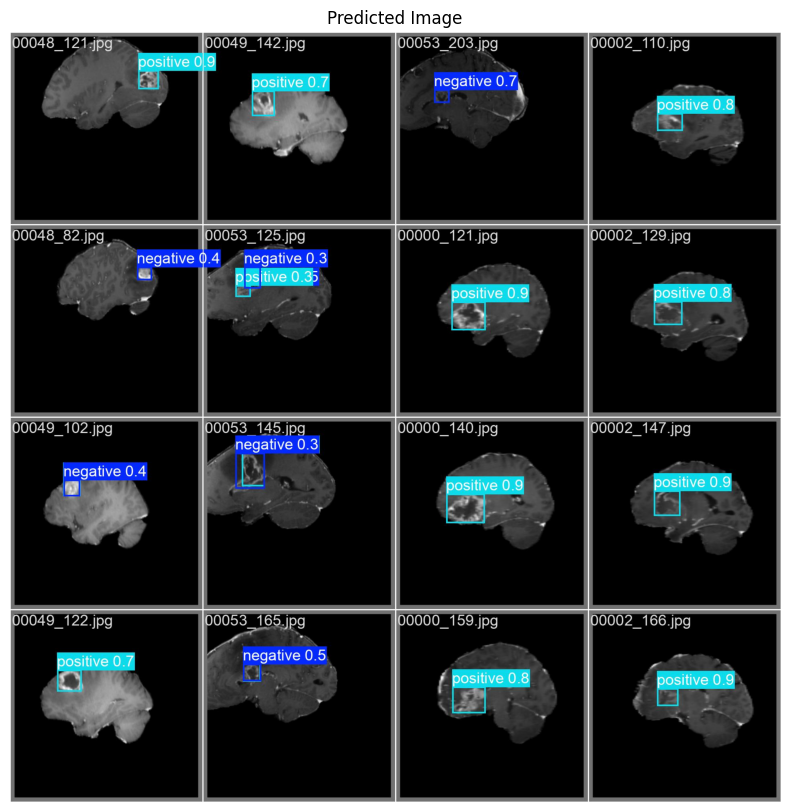

In [ ]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [ ]:
import os
real_path = os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg')

NameError: name 'random_file' is not defined

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g5hsh088
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g5hsh088
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d32ec83f527e08587789dc443379b009e0c4ab9d2ba3a159fb60570289c3d001
  Stored in directory: /tmp/pip-ephem-wheel-cache-udgy87qw/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2024-09-15 00:06:13--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  5.79MB/s    in 4m 42s  

2024-09-15 00:10:55 (8.67 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import cv2
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

NameError: name 'real_path' is not defined

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]

In [ ]:
print(bbox)

In [ ]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()